# Setup

### Imports / Constants / Functions

In [99]:
# Disable Tensorflow's warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [217]:
import tensorflow as tf


import pathlib
# from typing import Any,Union

import numpy as np
import matplotlib.pyplot as plt
import pickle
from PIL import Image

In [101]:
IMG_HEIGHT  = 228
IMG_WIDTH   = 228

In [102]:
def display_image(x, n):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.array(x[i]).astype('uint8'), vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def display_image2(x, n):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.array(x[i]), vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Load Data

In [103]:
BATCH_SIZE = 64

In [104]:
# Train
dataset = tf.keras.utils.image_dataset_from_directory('data/0_data_unseen/',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Convert BatchDataset to np array 
dataset = np.concatenate(list(dataset.map(lambda x, y: x))) 

Found 4 files belonging to 1 classes.


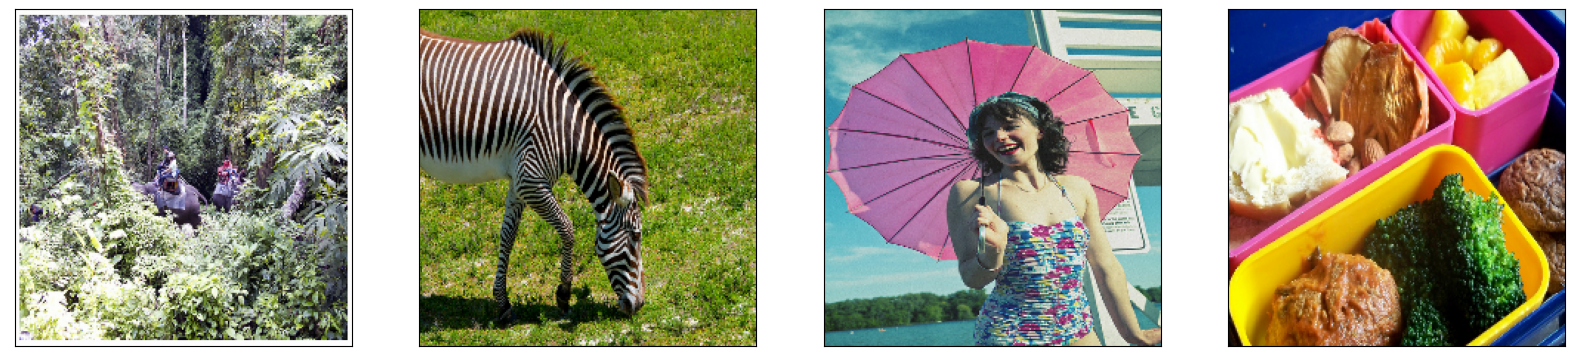

array([[[255.     , 253.     , 254.     ],
        [254.0247 , 252.83495, 253.42982],
        [253.42982, 253.42982, 253.42982],
        ...,
        [253.42982, 253.42982, 253.42982],
        [254.0247 , 252.83495, 253.42982],
        [255.     , 253.     , 254.     ]],

       [[255.     , 253.     , 254.     ],
        [253.49515, 252.9162 , 253.20567],
        [253.     , 253.     , 253.     ],
        ...,
        [253.     , 253.     , 253.     ],
        [253.28949, 252.71051, 253.     ],
        [254.     , 252.     , 253.     ]],

       [[254.01439, 253.98561, 254.     ],
        [253.     , 253.     , 253.     ],
        [252.     , 252.     , 252.     ],
        ...,
        [252.07195, 252.07195, 252.07195],
        [253.24632, 253.24632, 253.24632],
        [254.14912, 253.85088, 254.     ]],

       ...,

       [[253.11089, 253.0821 , 253.0965 ],
        [253.10594, 253.10594, 253.10594],
        [252.55962, 252.55962, 252.55962],
        ...,
        [252.55965, 252.55

In [223]:
display_image(dataset, 4)

# Binary Classifier (Deliverable 1)

In [106]:
# Import Classifier Model
bin_classifier_path = 'models/bin_10.19.2022_15:29:58_0.93%'
bin_classifier = tf.keras.models.load_model(bin_classifier_path)

OSError: No file or directory found at models/bin_10.19.2022_15:29:58_0.93%

In [ ]:
photos = []

predictions = bin_classifier.predict(dataset)

for prediction, image in zip(predictions, dataset):
    # If picture is photo, save it
    if int(np.round(prediction)) == 1:
            photos.append(image)

NameError: name 'bin_classifier' is not defined

In [ ]:
display_image(photos, len(photos))

# Autoencoder (Deliverable 2)

In [ ]:
# Prepare Dataset
photos = np.array(photos).astype('float32') / 255.
photos_dataset = tf.data.Dataset.from_tensor_slices(photos).batch(1)

In [ ]:
# Import Autoencoder Model
def ssim_accuracy(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

auto_encoder_path = 'models/autoenc_10.19.2022_17:39:08'
auto_encoder = tf.keras.models.load_model(auto_encoder_path, custom_objects={"ssim_accuracy":ssim_accuracy})

OSError: No file or directory found at models/autoenc_10.19.2022_17:39:08

In [ ]:
encoded_photos_dataset = auto_encoder.predict(photos_dataset)

NameError: name 'auto_encoder' is not defined

In [ ]:
display_image2(encoded_photos_dataset, len(encoded_photos_dataset))

# Captioning (Deliverable 3)

In [180]:
# Import Classifier Model
cap_decoder_path = 'models/cap_decoder_10.20.2022_11:33:51'
decoder = tf.keras.models.load_model(cap_decoder_path)
cap_encoder_path = 'models/cap_encoder_10.20.2022_10:59:21'
encoder = tf.keras.models.load_model(cap_encoder_path)

In [181]:
with open('train_captions', 'rb') as file:
    train_captions = pickle.load(file)

In [204]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

keras.layers.preprocessing.string_lookup.StringLookup

In [183]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [184]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [232]:
max_length = 7
attention_features_shape = 64

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(tf.convert_to_tensor(image), 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tf.cast(word_to_index('<start>'),tf.int64)], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder.call(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.cast(tf.expand_dims([predicted_id], 0),tf.int64)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [242]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: tops. light decorated contains cabinets. sticker its


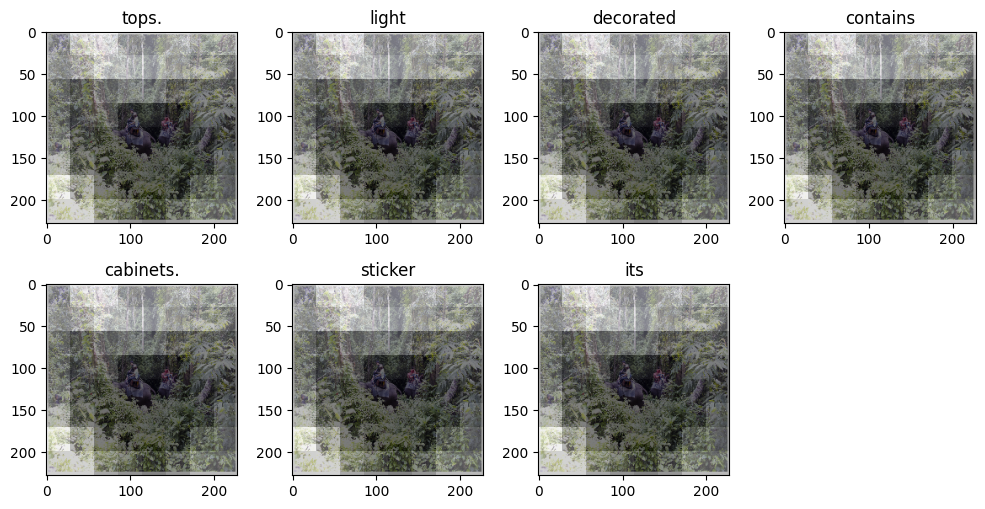

In [245]:
img = tf.convert_to_tensor(dataset[0])
img = tf.keras.layers.Resizing(299, 299)(img)
img = tf.keras.applications.inception_v3.preprocess_input(img)

result, attention_plot = evaluate(img)

photo = np.array(dataset[0]).astype('float32') / 255.

print('Prediction Caption:', ' '.join(result))
plot_attention(photo, result, attention_plot)